# Task-Specific Analysis

This notebook provides deep analysis of performance patterns for specific task types: Graph Classification, Node Classification, and Link Prediction.

## Step 3.1: Graph Classification Analysis

**Focus:** Deep analysis of graph classification performance (ENZYMES, PTC_MR)

**Objectives:**
- Extract and analyze ENZYMES and PTC_MR results
- Compare performance patterns between datasets
- Identify most effective pre-training schemes for graph-level tasks
- Statistical comparison and transferable insights


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu, spearmanr
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Define paths
RESULTS_DIR = Path('results')
FIGURES_DIR = Path('figures')
FIGURES_DIR.mkdir(exist_ok=True)

print("Task-Specific Analysis Setup Complete!")


Task-Specific Analysis Setup Complete!


In [2]:
# Load the aggregated and raw data
try:
    # Load aggregated results
    agg_df = pd.read_csv(RESULTS_DIR / 'aggregated_results.csv')
    
    # Load raw experimental results
    raw_df = pd.read_csv(RESULTS_DIR / 'raw_experimental_results.csv')
    
    print(f"Loaded aggregated data: {len(agg_df)} combinations")
    print(f"Loaded raw data: {len(raw_df)} experiments")
    
    # Display basic info
    print("\nDomains available:")
    print(agg_df['domain_name'].unique())
    
    print("\nTask types:")
    print(agg_df['task_type'].unique())
    
except FileNotFoundError as e:
    print(f"Data files not found. Please ensure the previous analysis steps have been completed.")
    print(f"Missing file: {e.filename}")
    agg_df = raw_df = None


Loaded aggregated data: 108 combinations
Loaded raw data: 324 experiments

Domains available:
['CiteSeer_LP' 'CiteSeer_NC' 'Cora_LP' 'Cora_NC' 'ENZYMES' 'PTC_MR']

Task types:
['link_prediction' 'node_classification' 'graph_classification']


## Graph Classification Data Extraction and Overview


In [3]:
# Extract graph classification data
if agg_df is not None:
    # Filter for graph classification tasks
    graph_class_domains = ['ENZYMES', 'PTC_MR']
    graph_agg = agg_df[agg_df['domain_name'].isin(graph_class_domains)].copy()
    graph_raw = raw_df[raw_df['domain_name'].isin(graph_class_domains)].copy()
    
    print("=" * 60)
    print("GRAPH CLASSIFICATION DATA OVERVIEW")
    print("=" * 60)
    
    # Basic statistics
    print(f"\nDataset Characteristics:")
    for domain in graph_class_domains:
        domain_data = graph_agg[graph_agg['domain_name'] == domain]
        if not domain_data.empty:
            task_type = domain_data['task_type'].iloc[0]
            num_combinations = len(domain_data)
            print(f"  {domain}:")
            print(f"    - Task type: {task_type}")
            print(f"    - Combinations available: {num_combinations}")
            print(f"    - Schemes: {sorted(domain_data['pretrained_scheme'].unique())}")
            print(f"    - Strategies: {sorted(domain_data['finetune_strategy'].unique())}")
    
    # Performance overview
    print(f"\nPerformance Overview:")
    for domain in graph_class_domains:
        domain_data = graph_agg[graph_agg['domain_name'] == domain]
        if not domain_data.empty:
            accuracy_stats = domain_data['accuracy_mean'].describe()
            print(f"\n  {domain} Accuracy Statistics:")
            print(f"    - Mean: {accuracy_stats['mean']:.4f}")
            print(f"    - Std: {accuracy_stats['std']:.4f}")
            print(f"    - Min: {accuracy_stats['min']:.4f}")
            print(f"    - Max: {accuracy_stats['max']:.4f}")
            
            # Best performing combination
            best_idx = domain_data['accuracy_mean'].idxmax()
            best_combo = domain_data.loc[best_idx]
            print(f"    - Best: {best_combo['pretrained_scheme']}-{best_combo['finetune_strategy']} ({best_combo['accuracy_mean']:.4f})")
    
else:
    print("Cannot perform analysis without data. Please run previous steps first.")
    graph_agg = graph_raw = None


GRAPH CLASSIFICATION DATA OVERVIEW

Dataset Characteristics:
  ENZYMES:
    - Task type: graph_classification
    - Combinations available: 18
    - Schemes: ['b1', 'b2', 'b3', 'b4', 's1', 's2', 's3', 's4', 's5']
    - Strategies: ['full_finetune', 'linear_probe']
  PTC_MR:
    - Task type: graph_classification
    - Combinations available: 18
    - Schemes: ['b1', 'b2', 'b3', 'b4', 's1', 's2', 's3', 's4', 's5']
    - Strategies: ['full_finetune', 'linear_probe']

Performance Overview:

  ENZYMES Accuracy Statistics:
    - Mean: 0.5352
    - Std: 0.1063
    - Min: 0.3611
    - Max: 0.6667
    - Best: b1-full_finetune (0.6667)

  PTC_MR Accuracy Statistics:
    - Mean: 0.5370
    - Std: 0.0602
    - Min: 0.4095
    - Max: 0.6857
    - Best: s1-full_finetune (0.6857)


## Scheme Effectiveness Analysis for Graph Classification


In [4]:
# Analyze scheme effectiveness for graph classification
if graph_agg is not None:
    print("=" * 60)
    print("SCHEME EFFECTIVENESS FOR GRAPH CLASSIFICATION")
    print("=" * 60)
    
    # Calculate baseline performance for each domain
    baseline_performance = {}
    for domain in graph_class_domains:
        baseline_data = graph_agg[
            (graph_agg['domain_name'] == domain) & 
            (graph_agg['pretrained_scheme'] == 'b1')
        ]
        if not baseline_data.empty:
            baseline_performance[domain] = baseline_data['accuracy_mean'].mean()
    
    print(f"\nBaseline Performance (b1):")
    for domain, perf in baseline_performance.items():
        print(f"  {domain}: {perf:.4f}")
    
    # Analyze scheme performance and improvement over baseline
    scheme_analysis = []
    schemes = sorted(graph_agg['pretrained_scheme'].unique())
    
    for domain in graph_class_domains:
        if domain not in baseline_performance:
            continue
            
        baseline_perf = baseline_performance[domain]
        domain_data = graph_agg[graph_agg['domain_name'] == domain]
        
        for scheme in schemes:
            scheme_data = domain_data[domain_data['pretrained_scheme'] == scheme]
            if not scheme_data.empty:
                mean_acc = scheme_data['accuracy_mean'].mean()
                std_acc = scheme_data['accuracy_mean'].std()
                improvement = ((mean_acc - baseline_perf) / baseline_perf) * 100
                
                # Calculate rank within domain
                domain_scheme_means = domain_data.groupby('pretrained_scheme')['accuracy_mean'].mean()
                rank = domain_scheme_means.rank(ascending=False)[scheme]
                
                scheme_analysis.append({
                    'domain': domain,
                    'scheme': scheme,
                    'mean_accuracy': mean_acc,
                    'std_accuracy': std_acc,
                    'improvement_pct': improvement,
                    'rank_in_domain': rank,
                    'num_combinations': len(scheme_data)
                })
    
    scheme_df = pd.DataFrame(scheme_analysis)
    
    print(f"\nScheme Performance Analysis:")
    print(scheme_df.round(4))
    
    # Best schemes per domain
    print(f"\nBest Schemes per Domain:")
    for domain in graph_class_domains:
        domain_schemes = scheme_df[scheme_df['domain'] == domain]
        if not domain_schemes.empty:
            best_scheme = domain_schemes.loc[domain_schemes['improvement_pct'].idxmax()]
            print(f"  {domain}: {best_scheme['scheme']} (+{best_scheme['improvement_pct']:.2f}%, rank {best_scheme['rank_in_domain']:.0f})")
    
    # Save the analysis results
    scheme_df.to_csv(RESULTS_DIR / 'graph_classification_analysis.csv', index=False)
    print(f"\nAnalysis saved to: {RESULTS_DIR / 'graph_classification_analysis.csv'}")
    
else:
    scheme_df = None


SCHEME EFFECTIVENESS FOR GRAPH CLASSIFICATION

Baseline Performance (b1):
  ENZYMES: 0.5806
  PTC_MR: 0.5286

Scheme Performance Analysis:
     domain scheme  mean_accuracy  std_accuracy  improvement_pct  \
0   ENZYMES     b1         0.5806        0.1218           0.0000   
1   ENZYMES     b2         0.5500        0.1179          -5.2632   
2   ENZYMES     b3         0.4972        0.1925         -14.3541   
3   ENZYMES     b4         0.5444        0.1650          -6.2201   
4   ENZYMES     s1         0.4750        0.1375         -18.1818   
5   ENZYMES     s2         0.5417        0.1218          -6.6986   
6   ENZYMES     s3         0.5361        0.1296          -7.6555   
7   ENZYMES     s4         0.5333        0.1257          -8.1340   
8   ENZYMES     s5         0.5583        0.1296          -3.8278   
9    PTC_MR     b1         0.5286        0.0337           0.0000   
10   PTC_MR     b2         0.5619        0.0000           6.3063   
11   PTC_MR     b3         0.5190        0.03

## Cross-Dataset Consistency Analysis


In [5]:
# Analyze consistency between ENZYMES and PTC_MR
if scheme_df is not None:
    print("=" * 60)
    print("CROSS-DATASET CONSISTENCY ANALYSIS")
    print("=" * 60)
    
    # Create pivot table for easier comparison
    pivot_improvement = scheme_df.pivot(index='scheme', columns='domain', values='improvement_pct')
    pivot_rank = scheme_df.pivot(index='scheme', columns='domain', values='rank_in_domain')
    
    print(f"\nImprovement Percentage by Scheme:")
    print(pivot_improvement.round(2))
    
    print(f"\nRank by Scheme (1 = best):")
    print(pivot_rank.round(0))
    
    # Calculate correlation between datasets
    if 'ENZYMES' in pivot_improvement.columns and 'PTC_MR' in pivot_improvement.columns:
        # Remove NaN values for correlation calculation
        valid_data = pivot_improvement.dropna()
        
        if len(valid_data) > 1:
            # Performance correlation
            perf_corr, perf_p = spearmanr(valid_data['ENZYMES'], valid_data['PTC_MR'])
            print(f"\nPerformance Correlation:")
            print(f"  Spearman correlation: {perf_corr:.3f} (p={perf_p:.3f})")
            
            # Rank correlation
            valid_ranks = pivot_rank.dropna()
            if len(valid_ranks) > 1:
                rank_corr, rank_p = spearmanr(valid_ranks['ENZYMES'], valid_ranks['PTC_MR'])
                print(f"  Rank correlation: {rank_corr:.3f} (p={rank_p:.3f})")
            
            # Identify consistent performers
            print(f"\nConsistent Top Performers (top 3 in both datasets):")
            enzymes_top3 = valid_ranks['ENZYMES'].nsmallest(3).index
            ptc_top3 = valid_ranks['PTC_MR'].nsmallest(3).index
            consistent_top = set(enzymes_top3) & set(ptc_top3)
            
            if consistent_top:
                for scheme in consistent_top:
                    e_rank = valid_ranks.loc[scheme, 'ENZYMES']
                    p_rank = valid_ranks.loc[scheme, 'PTC_MR']
                    e_imp = valid_data.loc[scheme, 'ENZYMES']
                    p_imp = valid_data.loc[scheme, 'PTC_MR']
                    print(f"  {scheme}: ENZYMES rank {e_rank:.0f} (+{e_imp:.2f}%), PTC_MR rank {p_rank:.0f} (+{p_imp:.2f}%)")
            else:
                print(f"  No schemes consistently in top 3 for both datasets")
    
else:
    pivot_improvement = pivot_rank = None


CROSS-DATASET CONSISTENCY ANALYSIS

Improvement Percentage by Scheme:
domain  ENZYMES  PTC_MR
scheme                 
b1         0.00    0.00
b2        -5.26    6.31
b3       -14.35   -1.80
b4        -6.22    0.00
s1       -18.18   26.13
s2        -6.70    0.00
s3        -7.66    0.90
s4        -8.13   -7.21
s5        -3.83   -9.91

Rank by Scheme (1 = best):
domain  ENZYMES  PTC_MR
scheme                 
b1          1.0     5.0
b2          3.0     2.0
b3          8.0     7.0
b4          4.0     5.0
s1          9.0     1.0
s2          5.0     5.0
s3          6.0     3.0
s4          7.0     8.0
s5          2.0     9.0

Performance Correlation:
  Spearman correlation: -0.203 (p=0.600)
  Rank correlation: -0.203 (p=0.600)

Consistent Top Performers (top 3 in both datasets):
  b2: ENZYMES rank 3 (+-5.26%), PTC_MR rank 2 (+6.31%)


## Graph Classification Visualizations


Creating Graph Classification Visualizations...


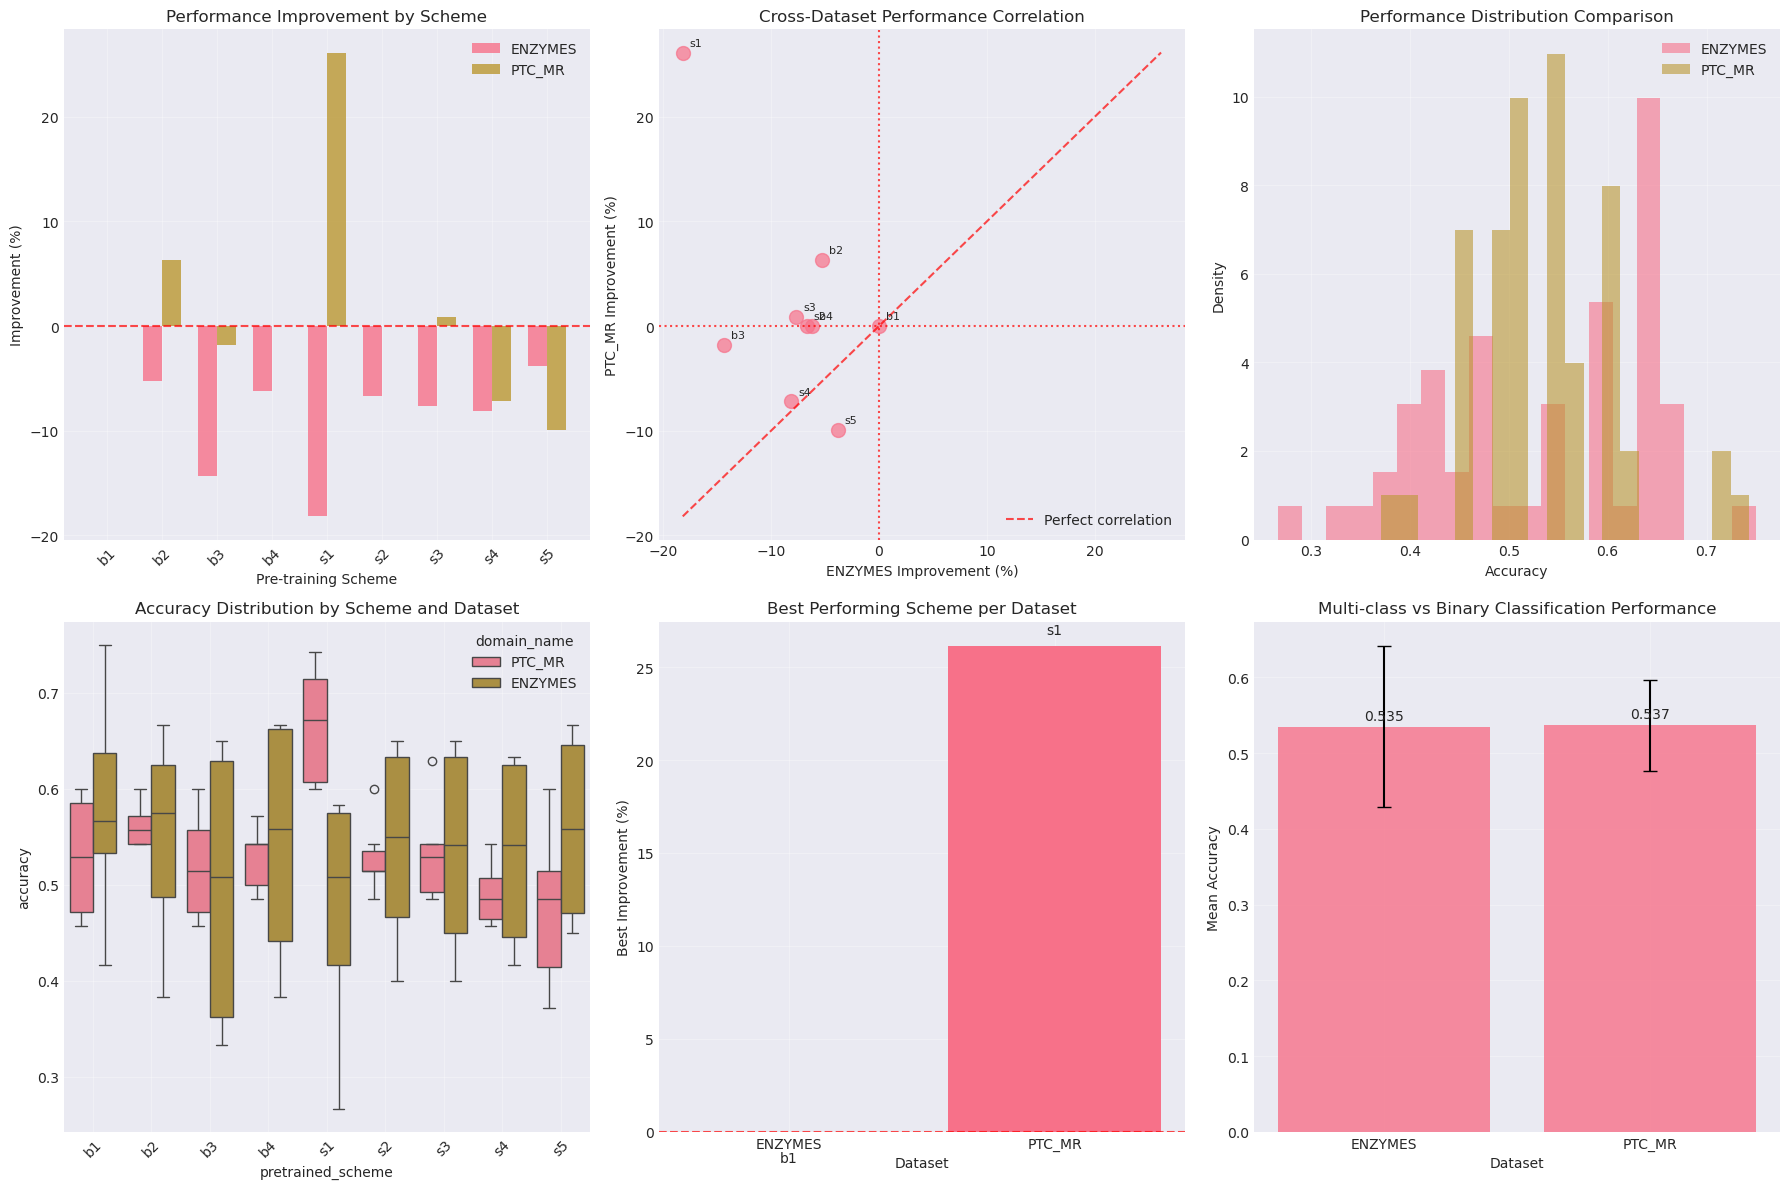

Graph classification visualization saved to: analysis/figures/graph_classification_comparison.png


In [6]:
# Create comprehensive visualizations for graph classification analysis
if scheme_df is not None and graph_raw is not None:
    print("Creating Graph Classification Visualizations...")
    
    plt.figure(figsize=(18, 12))
    
    # 1. Performance comparison by scheme
    plt.subplot(2, 3, 1)
    if pivot_improvement is not None:
        schemes = pivot_improvement.index
        x_pos = np.arange(len(schemes))
        width = 0.35
        
        enzymes_data = pivot_improvement['ENZYMES'].fillna(0)
        ptc_data = pivot_improvement['PTC_MR'].fillna(0)
        
        bars1 = plt.bar(x_pos - width/2, enzymes_data, width, label='ENZYMES', alpha=0.8)
        bars2 = plt.bar(x_pos + width/2, ptc_data, width, label='PTC_MR', alpha=0.8)
        
        plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
        plt.xlabel('Pre-training Scheme')
        plt.ylabel('Improvement (%)')
        plt.title('Performance Improvement by Scheme')
        plt.xticks(x_pos, schemes, rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # 2. Correlation scatter plot
    plt.subplot(2, 3, 2)
    if pivot_improvement is not None and 'ENZYMES' in pivot_improvement.columns and 'PTC_MR' in pivot_improvement.columns:
        valid_data = pivot_improvement.dropna()
        if not valid_data.empty:
            plt.scatter(valid_data['ENZYMES'], valid_data['PTC_MR'], alpha=0.7, s=100)
            
            # Add labels for each point
            for idx, scheme in enumerate(valid_data.index):
                plt.annotate(scheme, (valid_data.loc[scheme, 'ENZYMES'], valid_data.loc[scheme, 'PTC_MR']),
                           xytext=(5, 5), textcoords='offset points', fontsize=8)
            
            # Add diagonal line
            min_val = min(valid_data.min())
            max_val = max(valid_data.max())
            plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, label='Perfect correlation')
            
            plt.axhline(y=0, color='red', linestyle=':', alpha=0.7)
            plt.axvline(x=0, color='red', linestyle=':', alpha=0.7)
            plt.xlabel('ENZYMES Improvement (%)')
            plt.ylabel('PTC_MR Improvement (%)')
            plt.title('Cross-Dataset Performance Correlation')
            plt.legend()
            plt.grid(True, alpha=0.3)
    
    # 3. Performance distribution by dataset
    plt.subplot(2, 3, 3)
    enzymes_data = graph_raw[graph_raw['domain_name'] == 'ENZYMES']['accuracy']
    ptc_data = graph_raw[graph_raw['domain_name'] == 'PTC_MR']['accuracy']
    
    plt.hist(enzymes_data, alpha=0.6, label='ENZYMES', bins=20, density=True)
    plt.hist(ptc_data, alpha=0.6, label='PTC_MR', bins=20, density=True)
    plt.xlabel('Accuracy')
    plt.ylabel('Density')
    plt.title('Performance Distribution Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. Box plot by scheme
    plt.subplot(2, 3, 4)
    graph_raw_plot = graph_raw.copy()
    sns.boxplot(data=graph_raw_plot, x='pretrained_scheme', y='accuracy', hue='domain_name')
    plt.xticks(rotation=45)
    plt.title('Accuracy Distribution by Scheme and Dataset')
    plt.grid(True, alpha=0.3)
    
    # 5. Best scheme visualization
    plt.subplot(2, 3, 5)
    best_schemes_data = []
    for domain in graph_class_domains:
        domain_data = scheme_df[scheme_df['domain'] == domain]
        if not domain_data.empty:
            best_scheme = domain_data.loc[domain_data['improvement_pct'].idxmax()]
            best_schemes_data.append({
                'domain': domain,
                'best_scheme': best_scheme['scheme'],
                'improvement': best_scheme['improvement_pct']
            })
    
    if best_schemes_data:
        best_df = pd.DataFrame(best_schemes_data)
        bars = plt.bar(best_df['domain'], best_df['improvement'])
        plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
        
        # Add scheme labels on bars
        for bar, scheme in zip(bars, best_df['best_scheme']):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + (0.5 if height > 0 else -1),
                    scheme, ha='center', va='bottom' if height > 0 else 'top', fontsize=10)
        
        plt.xlabel('Dataset')
        plt.ylabel('Best Improvement (%)')
        plt.title('Best Performing Scheme per Dataset')
        plt.grid(True, alpha=0.3)
    
    # 6. Multi-class vs Binary comparison
    plt.subplot(2, 3, 6)
    dataset_performance = graph_agg.groupby('domain_name')['accuracy_mean'].agg(['mean', 'std']).reset_index()
    
    bars = plt.bar(dataset_performance['domain_name'], dataset_performance['mean'], 
                  yerr=dataset_performance['std'], capsize=5, alpha=0.8)
    
    # Add value labels
    for bar, mean_val in zip(bars, dataset_performance['mean']):
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.005,
                f'{mean_val:.3f}', ha='center', va='bottom', fontsize=10)
    
    plt.xlabel('Dataset')
    plt.ylabel('Mean Accuracy')
    plt.title('Multi-class vs Binary Classification Performance')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'graph_classification_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Graph classification visualization saved to: analysis/figures/graph_classification_comparison.png")
    
else:
    print("Cannot create visualizations without data. Please ensure previous steps completed successfully.")


## Summary and Recommendations


In [7]:
# Generate summary and recommendations for graph classification
if scheme_df is not None:
    print("=" * 60)
    print("GRAPH CLASSIFICATION SUMMARY AND RECOMMENDATIONS")
    print("=" * 60)
    
    # Key findings
    print("\nKEY FINDINGS:")
    
    # Best overall schemes
    overall_improvement = scheme_df.groupby('scheme')['improvement_pct'].mean().sort_values(ascending=False)
    print(f"\n1. BEST PERFORMING SCHEMES (average improvement):")
    for i, (scheme, improvement) in enumerate(overall_improvement.head(3).items()):
        print(f"   {i+1}. {scheme}: {improvement:.2f}%")
    
    # Dataset-specific findings
    print(f"\n2. DATASET-SPECIFIC INSIGHTS:")
    for domain in graph_class_domains:
        domain_data = scheme_df[scheme_df['domain'] == domain]
        if not domain_data.empty:
            best = domain_data.loc[domain_data['improvement_pct'].idxmax()]
            worst = domain_data.loc[domain_data['improvement_pct'].idxmin()]
            print(f"   {domain}:")
            print(f"     - Best: {best['scheme']} (+{best['improvement_pct']:.2f}%)")
            print(f"     - Worst: {worst['scheme']} ({worst['improvement_pct']:.2f}%)")
            print(f"     - Range: {best['improvement_pct'] - worst['improvement_pct']:.2f}%")
    
    # Consistency analysis
    if pivot_improvement is not None and len(pivot_improvement.columns) >= 2:
        valid_data = pivot_improvement.dropna()
        if len(valid_data) > 1:
            corr_coef = np.corrcoef(valid_data.iloc[:, 0], valid_data.iloc[:, 1])[0, 1]
            print(f"\n3. CROSS-DATASET CONSISTENCY:")
            print(f"   - Performance correlation: {corr_coef:.3f}")
            print(f"   - Consistency level: {'High' if abs(corr_coef) > 0.7 else 'Moderate' if abs(corr_coef) > 0.4 else 'Low'}")
    
    # Recommendations
    print(f"\n4. RECOMMENDATIONS FOR GRAPH CLASSIFICATION:")
    
    top_3_schemes = overall_improvement.head(3).index.tolist()
    print(f"   - Recommended schemes: {', '.join(top_3_schemes)}")
    
    # Task-specific recommendations
    enzymes_best = scheme_df[scheme_df['domain'] == 'ENZYMES'].loc[scheme_df[scheme_df['domain'] == 'ENZYMES']['improvement_pct'].idxmax(), 'scheme']
    ptc_best = scheme_df[scheme_df['domain'] == 'PTC_MR'].loc[scheme_df[scheme_df['domain'] == 'PTC_MR']['improvement_pct'].idxmax(), 'scheme']
    
    print(f"   - For multi-class graph classification (similar to ENZYMES): Use {enzymes_best}")
    print(f"   - For binary graph classification (similar to PTC_MR): Use {ptc_best}")
    
    # Strategy recommendations
    if graph_agg is not None:
        strategy_performance = graph_agg.groupby('finetune_strategy')['accuracy_mean'].mean()
        best_strategy = strategy_performance.idxmax()
        print(f"   - Recommended fine-tuning strategy: {best_strategy}")
    
    print(f"\nAnalysis complete! Results saved to: analysis/results/graph_classification_analysis.csv")
    
else:
    print("Cannot generate recommendations without completed analysis.")


GRAPH CLASSIFICATION SUMMARY AND RECOMMENDATIONS

KEY FINDINGS:

1. BEST PERFORMING SCHEMES (average improvement):
   1. s1: 3.97%
   2. b2: 0.52%
   3. b1: 0.00%

2. DATASET-SPECIFIC INSIGHTS:
   ENZYMES:
     - Best: b1 (+0.00%)
     - Worst: s1 (-18.18%)
     - Range: 18.18%
   PTC_MR:
     - Best: s1 (+26.13%)
     - Worst: s5 (-9.91%)
     - Range: 36.04%

3. CROSS-DATASET CONSISTENCY:
   - Performance correlation: -0.622
   - Consistency level: Moderate

4. RECOMMENDATIONS FOR GRAPH CLASSIFICATION:
   - Recommended schemes: s1, b2, b1
   - For multi-class graph classification (similar to ENZYMES): Use b1
   - For binary graph classification (similar to PTC_MR): Use s1
   - Recommended fine-tuning strategy: full_finetune

Analysis complete! Results saved to: analysis/results/graph_classification_analysis.csv
